# Clustering Feature Requests into Common Requests

The purpose of this notebook is to extract topics and label cases based on the newly found topics for the Feature Requests - Vague, general, unusual KA.

It is believed that this KA will have recurring requests from different customers possibly enough to create a new specific KA or at least improve the Feature Request reporting.

The outline of this notebook will be:
* Import data using Pandas
* Clean the data using regex, and NLTK (likely to be a seperate module at a later date)
* TF-IDF the data
* Optimise the number of the clusters
* Run K-Means on the TF-IDF
* Run K-Means on a Bigram version of the TF-IDF
* Compare performance
* Run Non-negative Matrix Factorisation on the data for Topic Extraction (mainly for a sanity check).

Going forward, this code will be a single script with possibly a lite front-end for end users to be able to run it.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import nltk
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

% matplotlib inline

## Import and clean data

In [2]:
data = pd.read_csv('./data/feature_export.csv', usecols=[2,3],
                  names=['subject', 'description'],
                  header=0,
                  encoding='utf-8')

data = data.fillna('empty')
data.head()

,subject,description
0,Edit bank statement,"Hi Team,\n\nI need a healp please call me on t..."
1,Link a foreign supplier to a foreign currency ...,Hi \n\nWe have foreign supplier settle with di...
2,Edit User's Email Address?,"Good afternoon,\n\nIs there a way to edit a us..."
3,Allow only 3ds in stripe integration,Stripe informed Xero need to change Stripe int...
4,Vigilant Technologies,"Hi Support,\n\nPlease advise on the following:..."


In [46]:
# Output blocked for github.
"""
print "Example case we want to clean:"
print
print 
print data.iloc[2]['description']

"""

'\nprint "Example case we want to clean:"\nprint\nprint \nprint data.iloc[2][\'description\']\n\n'

In [249]:
data['description'] = data['description'].str.replace(r'([a-z0-9_\.-]+)@([\da-z\.-]+)\.([a-z\.]{2,6})', '') # Removes emails

In [250]:
data['description'] = data['description'].str.replace(r'<(.*?)\>', '') # removes contents between <> tags, eg html

In [ ]:
data['description'] = data['description'].str.replace(r'\[(.*?)\]', '') # removes stuff between square brackets

In [251]:
data['description'] = data['description'].str.replace(r'[^\w\s]', '') 

In [252]:
data['description'] = data['description'].str.replace(r'www[a-z]+', '')

In [253]:
data['description'] = data['description'].str.replace(r'http[a-z]+', '')

In [254]:
data['description'] = data['description'].str.replace(r'https[a-z]+', '')

In [255]:
data['description'] = data['description'].str.replace(r'supportxerocom', '')

In [256]:
data['description'] = data['description'].str.replace(r'\d', '') # removes numbers eg phone numbers

In [257]:
data['description'] = data['description'].str.lower().str.split()

In [259]:
# Remove stopwords from text using NLTK.
stop = stopwords.words('english')
stop.append('hello')
stop.append('hi')
stop.append('dear')
stop.append('sir')
stop.append('sirs')
stop.append('thank')
stop.append('facebook')
stop.append('twitter')
stop.append('linkedin') # Newly added

In [260]:
data['description'] = data['description'].apply(lambda x: [item for item in x if item not in stop])

In [258]:
# Stem words for better model performance
stemmer = SnowballStemmer("english")
data['description'] = data['description'].apply(lambda x: [stemmer.stem(y) for y in x])

In [261]:
print data.iloc[2]['description']

[u'good', u'afternoon', u'way', u'edit', u'user', u'email', u'address', u'realiz', u'delet', u'readd', u'dont', u'want', u'go', u'hassl', u'edit', u'sincer', u'heather', u'coti', u'event', u'coordin', u'hr', u'social', u'media', u'product', u'ambassador', u'ex', u'like', u'us', u'follow', u'us', u'sign', u'newslett', u'join', u'us', u'culinari', u'tour', u'itali']


In [262]:
#data.to_csv('./data/cleaned_feature.csv',
#           encoding='utf-8')

In [3]:
cleaned = pd.read_csv('./data/final_feature.csv', usecols=[1],
                     header=0)

cleaned = cleaned.fillna('empty')

cleaned.head()

,description
0,team need healp pleas call
1,foreign supplier settl differ foreign currenc ...
2,good afternoon way edit user email address rea...
3,stripe inform xero need chang stripe integr on...
4,support pleas advis follow tri connect dbs dir...


In [4]:
#train, test = train_test_split(cleaned, test_size=0.1)
#test.to_csv('test_data.csv')

# K-Means Clustering

In [104]:
# Setup Vector
vectorizer = TfidfVectorizer(max_df=0.9,
                            min_df=0.001)
X = vectorizer.fit_transform(cleaned['description'])

In [105]:
X.shape

(2380, 2255)

Even by setting min_df=2 we drop the # of features from 13,000 to 3117. This saves on a lot of text cleaning.

In [114]:
true_k = 20 ## Initially set to 8, optimise later in script. Play around with clusters at later stage
model = KMeans(n_clusters=true_k,
               init='k-means++',
               max_iter=300)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [122]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")

Y = vectorizer.transform(["I want my invoice to show a bigger logo"])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["bank transaction doesn't have abiliy to edit"])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["report with custom running balance"])
prediction = model.predict(Y)
print(prediction)

Top terms per cluster:
Cluster 0:  colour  ui  chang  save  pdf  terribl  differ  font  confus  like
Cluster 1:  imag  inlin  account  xero  email  mobil  pleas  show  instagram  manag
Cluster 2:  email  address  send  invoic  quot  xero  contact  custom  copi  sent
Cluster 3:  item  line  inventori  code  price  invoic  cost  way  sale  abl
Cluster 4:  xero  account  would  regard  use  like  pleas  possibl  way  need
Cluster 5:  payment  batch  invoic  bill  bank  account  supplier  await  way  creat
Cluster 6:  balanc  statement  bank  show  sheet  account  credit  need  xero  import
Cluster 7:  client  xero  would  way  invoic  list  ani  account  need  use
Cluster 8:  year  month  end  report  account  last  xero  financi  want  current
Cluster 9:  transact  bank  account  reconcil  rule  feed  code  see  xero  import
Cluster 10:  file  export  xero  import  csv  upload  attach  way  pdf  direct
Cluster 11:  email  ani  intend  messag  confidenti  inform  recipi  may  pleas  copi


In [123]:
k_means_labels = model.labels_
k_means_labels

array([ 4,  4,  4, ..., 10, 18,  4])

In [124]:
unique, counts = np.unique(k_means_labels, return_counts=True)
dict(zip(unique, counts))

{0: 32,
 1: 36,
 2: 88,
 3: 75,
 4: 613,
 5: 87,
 6: 64,
 7: 115,
 8: 67,
 9: 162,
 10: 86,
 11: 174,
 12: 101,
 13: 66,
 14: 54,
 15: 39,
 16: 175,
 17: 67,
 18: 82,
 19: 197}

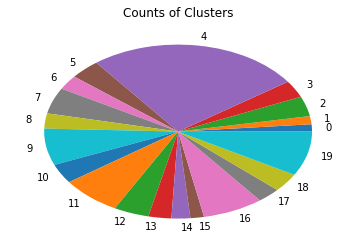

In [125]:
plt.pie(counts, labels=unique)
plt.title('Counts of Clusters')
plt.show()

In [127]:
data['labels'] = k_means_labels
data.to_csv('labelled.csv', encoding='utf-8')

# Optimising the number of clusters

For a metric, we're going to be using the Silhouette score. As time was contstained building this model, I didn't get a chance to build a custom metric, but the Silhouette score is the closest 'out of the box' metric I could find to the metric I was designing.

With KMeans, the only real parameter we have to specify is the number of clusters.

However, as found sudy by KTH, the feature selection and parameters used in the TF-IDF vectoriser play a large role in the overall success of the model.

In [120]:
from sklearn.metrics import silhouette_score

In [121]:
print silhouette_score(X, k_means_labels)

0.0176393210488


In [113]:
range_n_clusters = [8,10,15,20,25,30,35,40,45]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

('For n_clusters =', 8, 'The average silhouette_score is :', 0.013526861827847516)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.01455255726234924)
('For n_clusters =', 15, 'The average silhouette_score is :', 0.017415771370477708)
('For n_clusters =', 20, 'The average silhouette_score is :', 0.020319729704520059)
('For n_clusters =', 25, 'The average silhouette_score is :', 0.020040299450331665)
('For n_clusters =', 30, 'The average silhouette_score is :', 0.017280343829740235)
('For n_clusters =', 35, 'The average silhouette_score is :', 0.0189879407448619)
('For n_clusters =', 40, 'The average silhouette_score is :', 0.021092185193073407)
('For n_clusters =', 45, 'The average silhouette_score is :', 0.017997325621287349)


# K-Means Clustering with Bigrams

In [147]:
# Setup Vector
bi_vectorizer = TfidfVectorizer(max_df=0.9,
                            min_df=0.001,
                            ngram_range=(1, 2))
X_bigram = bi_vectorizer.fit_transform(cleaned['description'])

In [148]:
range_n_clusters = [8,10,15,20,25,30,35,40,45]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_bigram)
    
    silhouette_avg = silhouette_score(X_bigram, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

('For n_clusters =', 8, 'The average silhouette_score is :', 0.01127503987252519)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.011834285615702296)
('For n_clusters =', 15, 'The average silhouette_score is :', 0.012785695430088456)
('For n_clusters =', 20, 'The average silhouette_score is :', 0.014682359319775795)
('For n_clusters =', 25, 'The average silhouette_score is :', 0.015072953686658537)
('For n_clusters =', 30, 'The average silhouette_score is :', 0.012547086425126365)
('For n_clusters =', 35, 'The average silhouette_score is :', 0.014066093317359961)
('For n_clusters =', 40, 'The average silhouette_score is :', 0.01422715657261564)
('For n_clusters =', 45, 'The average silhouette_score is :', 0.01359711140660798)


From this, we can conclude that the Tf-idf vector on single words has a better model performance than that of the bigram vector across all cluster sixes. This is unexpected and contrary to the Academic paper I read.

It interesting and pleasing that the highest Silhouette score for both models is at the 20 Cluster size.

# Hierarchical Clustering

In [11]:
from sklearn.cluster import AgglomerativeClustering

In [12]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=30)

In [13]:
result_clustering = clustering.fit(X.toarray())

In [14]:
cluster_labels = clustering.labels_

In [15]:
cluster_labels

array([ 4, 26,  4, ...,  3,  4,  4], dtype=int64)

In [16]:
unique, counts = np.unique(cluster_labels, return_counts=True)
dict(zip(unique, counts))

{0: 195,
 1: 40,
 2: 18,
 3: 65,
 4: 927,
 5: 44,
 6: 119,
 7: 43,
 8: 41,
 9: 42,
 10: 157,
 11: 27,
 12: 38,
 13: 65,
 14: 36,
 15: 17,
 16: 145,
 17: 19,
 18: 19,
 19: 15,
 20: 25,
 21: 14,
 22: 59,
 23: 14,
 24: 25,
 25: 22,
 26: 35,
 27: 31,
 28: 66,
 29: 17}

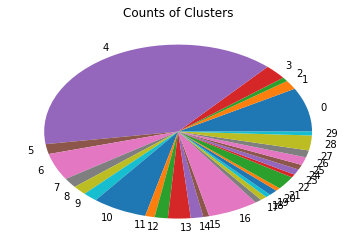

In [17]:
plt.pie(counts, labels=unique)
plt.title('Counts of Clusters')
plt.show()

In [31]:
aggo_feature_names = clustering.labels_
aggo_feature_names

array([ 4, 26,  4, ...,  3,  4,  4], dtype=int64)

# Non-negative Matrix Factorisation

The data in the form of a TF-IDF vector is naturally non-negative as it's essentially just the word frequencies in Cases.

In [137]:
from sklearn.decomposition import NMF

In [138]:
def display_topics(model, feature_names, top_words):
    """
    Function to print the top words of a given topic given a model
    """
    for topic_idx, topic in enumerate(model.components_):
        print "Topic %d:" % (topic_idx)
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-top_words - 1:-1]])

In [159]:
nmf = NMF(n_components= 8,
          alpha=0.1)

In [160]:
nmf.fit(X)

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=8, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [161]:
tfidf_feature_names = vectorizer.get_feature_names()
display_topics(nmf, tfidf_feature_names, top_words=15)

Topic 0:
bank account transact bank account reconcil payment code feed bank feed rule statement balanc import bank statement expens
Topic 1:
email ani intend messag inform confidenti recipi may pleas attach copi intend recipi contain receiv error
Topic 2:
invoic custom payment sale way sale invoic date send creat number quot line one email paid
Topic 3:
version app iphon ui os version ui languag app version os model organis name languag usernam usernam organis organis version ui
Topic 4:
report show run month date report show balanc run report get budget year includ total period report run
Topic 5:
xero client regard file imag user support pleas kind kind regard use account need want access
Topic 6:
order purchas purchas order bill item supplier number price way order number inventori sale alphabet deliveri alphabet order
Topic 7:
would like would like possibl add abl like abl item custom field column featur like add like know great


In [162]:
nmf_bigram = NMF(n_components=8,
                alpha=0.1)
nmf_bigram.fit(X_bigram)

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=8, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [163]:
bigram_feature_names = bi_vectorizer.get_feature_names()
display_topics(nmf_bigram, bigram_feature_names, top_words=15)

Topic 0:
bank account transact bank account reconcil payment code feed bank feed rule statement balanc import bank statement expens
Topic 1:
email ani intend messag inform confidenti recipi may pleas attach copi intend recipi contain receiv error
Topic 2:
invoic custom payment sale way sale invoic date send creat number quot line one email paid
Topic 3:
version app iphon ui os version ui languag app version os model organis name languag usernam usernam organis organis version ui
Topic 4:
report show run month date report show balanc run report get budget year includ total period report run
Topic 5:
xero client regard file imag user support pleas kind kind regard use account need want access
Topic 6:
order purchas purchas order bill item supplier number price way order number inventori sale alphabet deliveri alphabet order
Topic 7:
would like would like possibl add abl like abl custom item field column featur like add like know great
